In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
from google.colab import files
uploaded = files.upload()

Saving sales_data (1).csv to sales_data (1).csv


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv("sales_data (1).csv")
print(f"Original data shape: {df.shape}")

Original data shape: (76000, 16)


Time series data shape: (760, 1)
Time range: 2022-01-01 00:00:00 to 2024-01-30 00:00:00


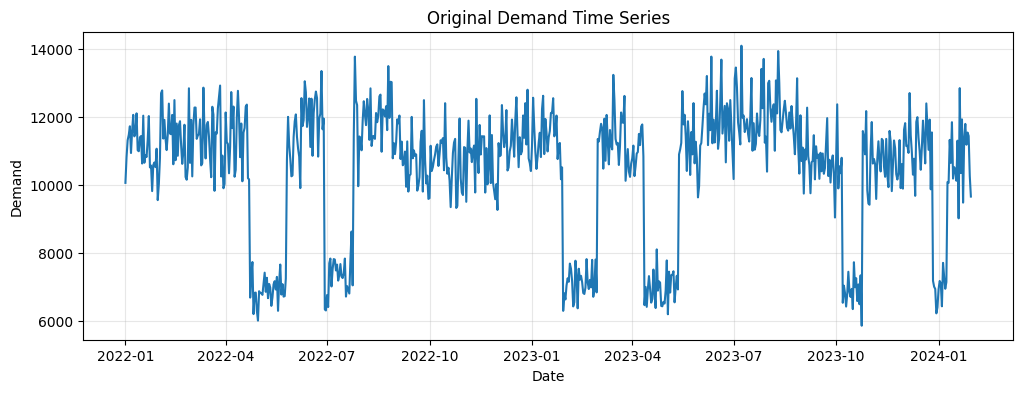

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

daily_demand = df.groupby('Date')['Demand'].sum().reset_index()
daily_demand.set_index('Date', inplace=True)
daily_demand.sort_index(inplace=True)

print(f"Time series data shape: {daily_demand.shape}")
print(f"Time range: {daily_demand.index.min()} to {daily_demand.index.max()}")
plt.figure(figsize=(12, 4))
plt.plot(daily_demand.index, daily_demand['Demand'])
plt.title('Original Demand Time Series')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.grid(True, alpha=0.3)
plt.show()

Original series stationarity test:
ADF Statistic: -4.881631
p-value: 0.000038
 Series is stationary


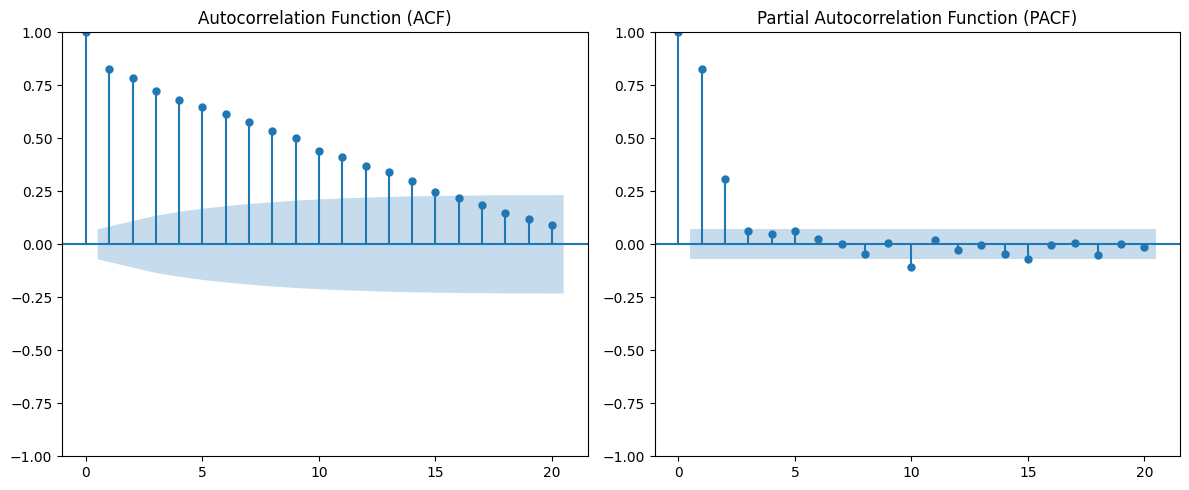

In [7]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')

    if result[1] <= 0.05:
        print(" Series is stationary")
        return True
    else:
        print(" Series is non-stationary, differencing needed")
        return False

print("Original series stationarity test:")
is_stationary = check_stationarity(daily_demand['Demand'])

demand_series = daily_demand['Demand'].copy()
diff_order = 0

if not is_stationary:
    demand_diff = demand_series.diff().dropna()
    print("\nFirst-order differenced series stationarity test:")
    if check_stationarity(demand_diff):
        demand_series = demand_diff
        diff_order = 1
    else:
        print("Using original series for analysis")
        demand_series = daily_demand['Demand']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(demand_series.dropna(), ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(demand_series.dropna(), ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [8]:
def find_best_arima(data, max_p=3, max_q=3):
    best_aic = float('inf')
    best_params = None
    best_model = None

    print("Finding optimal ARIMA parameters...")
    print("Parameters\t\tAIC Value")
    print("-" * 30)

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                model = ARIMA(data, order=(p, diff_order, q))
                fitted_model = model.fit()
                aic = fitted_model.aic

                print(f"({p},{diff_order},{q})\t\t{aic:.2f}")

                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, diff_order, q)
                    best_model = fitted_model

            except:
                continue

    return best_model, best_params

best_model, best_params = find_best_arima(daily_demand['Demand'])
print(f"\nOptimal ARIMA parameters: {best_params}")
print(f"Best AIC value: {best_model.aic:.4f}")

Finding optimal ARIMA parameters...
Parameters		AIC Value
------------------------------
(0,0,0)		13632.41
(0,0,1)		13215.10
(0,0,2)		13002.21
(0,0,3)		12889.55
(1,0,0)		12751.84
(1,0,1)		12674.30
(1,0,2)		12675.96
(1,0,3)		12675.44
(2,0,0)		12678.23
(2,0,1)		12675.80
(2,0,2)		12677.13
(2,0,3)		12677.43
(3,0,0)		12677.33
(3,0,1)		12676.21
(3,0,2)		12677.93
(3,0,3)		12674.65

Optimal ARIMA parameters: (1, 0, 1)
Best AIC value: 12674.3019



Model evaluation results:
MAE: 1259.6386
RMSE: 1720.4037
R²: 0.0712


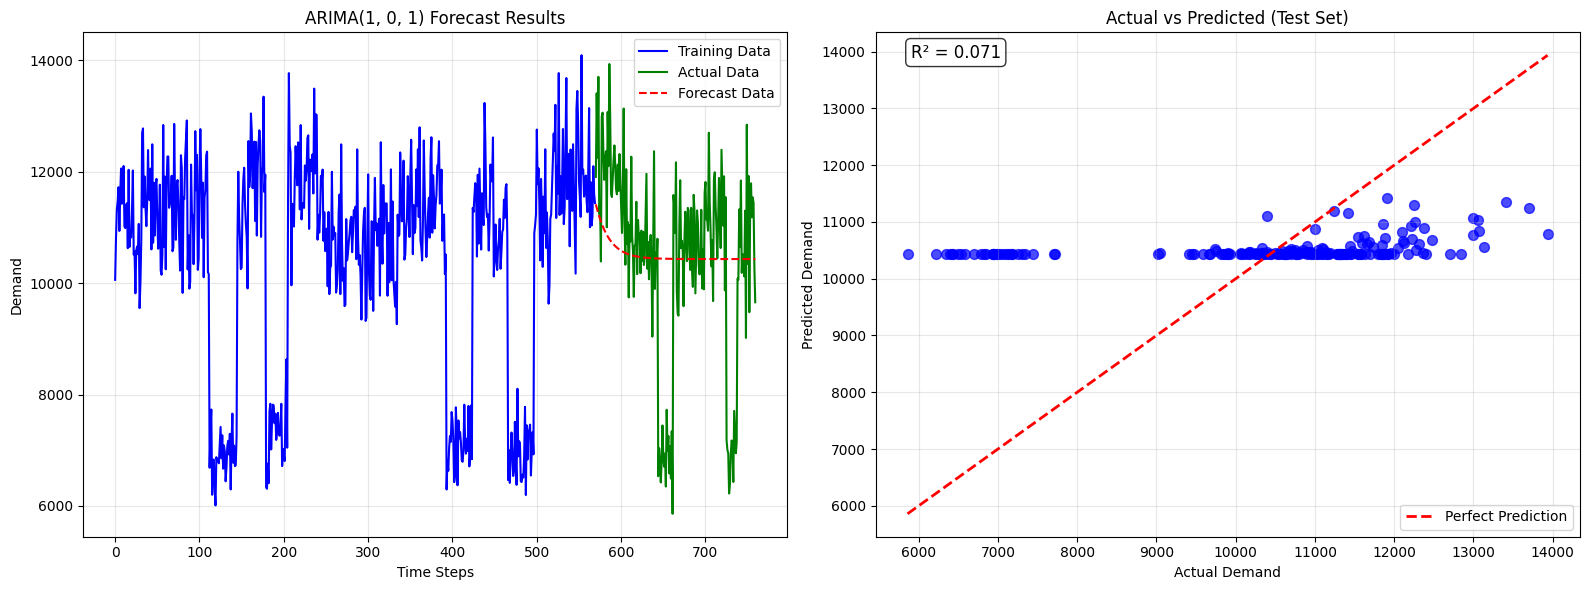

In [9]:
train_size = int(len(daily_demand) * 0.75)
train_data = daily_demand['Demand'][:train_size]
test_data = daily_demand['Demand'][train_size:]

if len(test_data) > 0:

    train_model = ARIMA(train_data, order=best_params).fit()

    forecast = train_model.forecast(steps=len(test_data))

    mae = mean_absolute_error(test_data, forecast)
    mse = mean_squared_error(test_data, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, forecast)

    print(f"\nModel evaluation results:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


    ax1.plot(range(len(train_data)), train_data, label='Training Data', color='blue')
    ax1.plot(range(len(train_data), len(train_data) + len(test_data)),
             test_data, label='Actual Data', color='green')
    ax1.plot(range(len(train_data), len(train_data) + len(forecast)),
             forecast, label='Forecast Data', color='red', linestyle='--')
    ax1.set_title(f'ARIMA{best_params} Forecast Results')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Demand')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.scatter(test_data, forecast, alpha=0.7, color='blue', s=50)

    min_val = min(min(test_data), min(forecast))
    max_val = max(max(test_data), max(forecast))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--',
             linewidth=2, label='Perfect Prediction')

    ax2.set_xlabel('Actual Demand')
    ax2.set_ylabel('Predicted Demand')
    ax2.set_title('Actual vs Predicted (Test Set)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ax2.text(0.05, 0.95, f'R² = {r2:.3f}', transform=ax2.transAxes,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             fontsize=12)

    plt.tight_layout()
    plt.show()


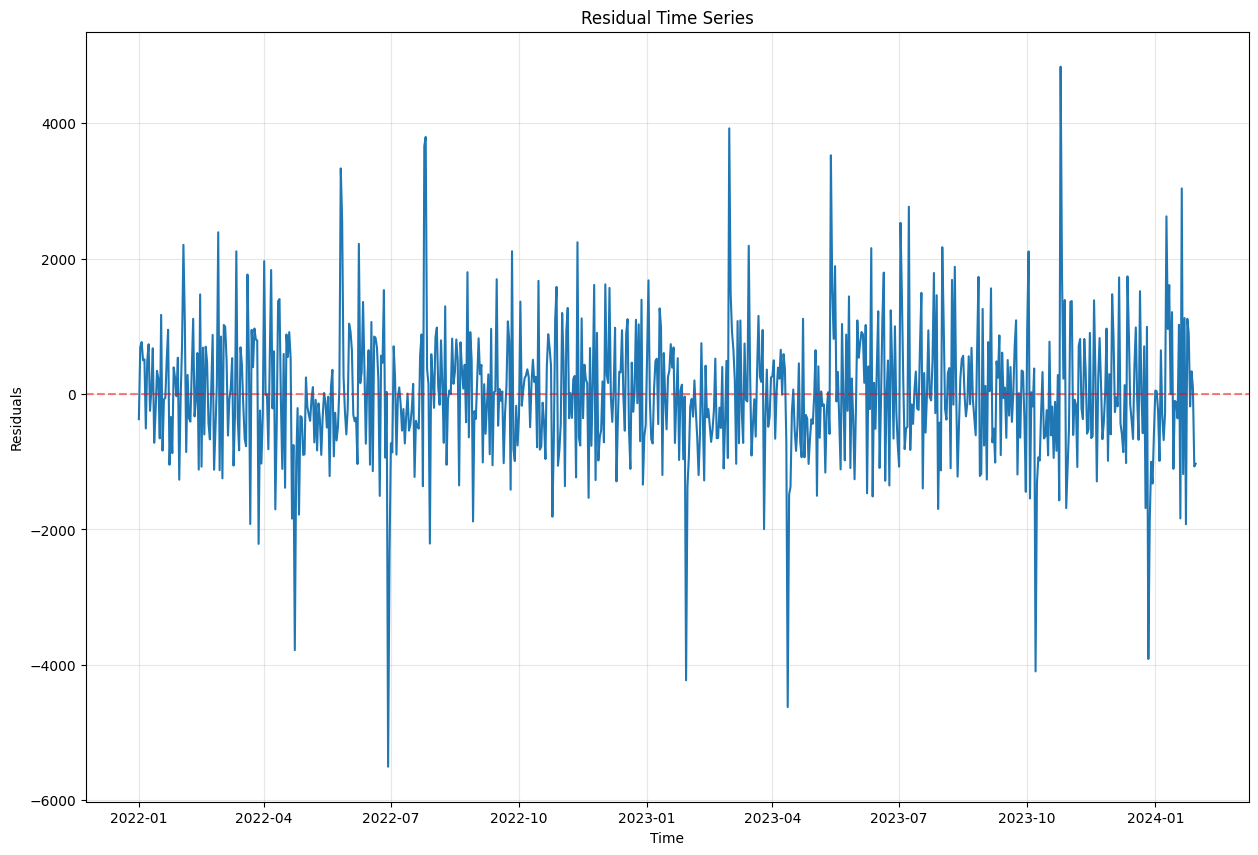

In [10]:
residuals = best_model.resid

plt.figure(figsize=(15, 10))

plt.subplot(1, 1, 1)
plt.plot(residuals)
plt.title('Residual Time Series')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

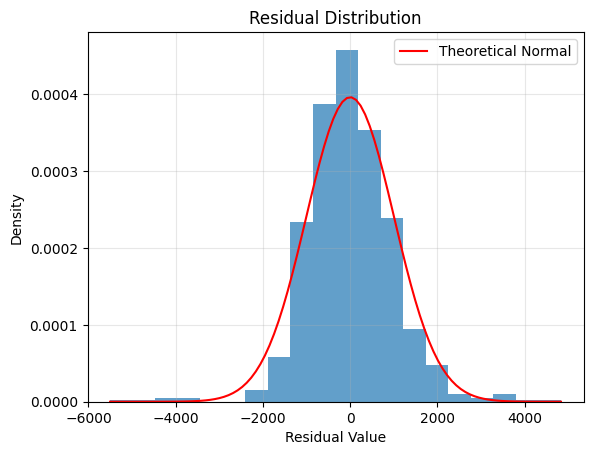

In [11]:
plt.subplot(1, 1, 1)
plt.hist(residuals.dropna(), bins=20, alpha=0.7, density=True)
plt.title('Residual Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)


x = np.linspace(residuals.min(), residuals.max(), 100)
y = ((1/np.sqrt(2*np.pi*residuals.std()**2)) *
     np.exp(-0.5*((x-residuals.mean())/residuals.std())**2))
plt.plot(x, y, 'r-', label='Theoretical Normal')
plt.legend()

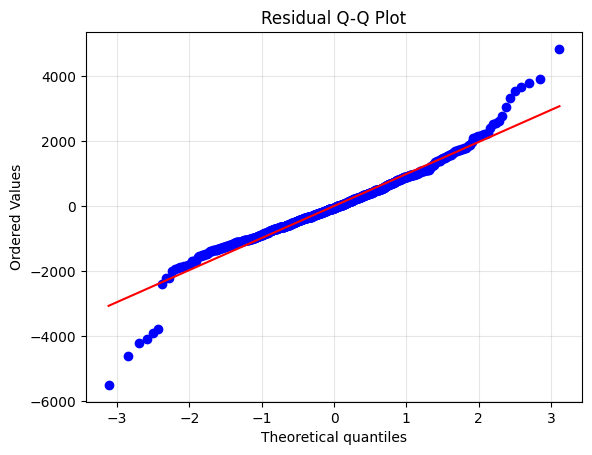

In [12]:
plt.subplot(1, 1, 1)
from scipy import stats
stats.probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title('Residual Q-Q Plot')
plt.grid(True, alpha=0.3)

Text(0.5, 1.0, 'Residual ACF')

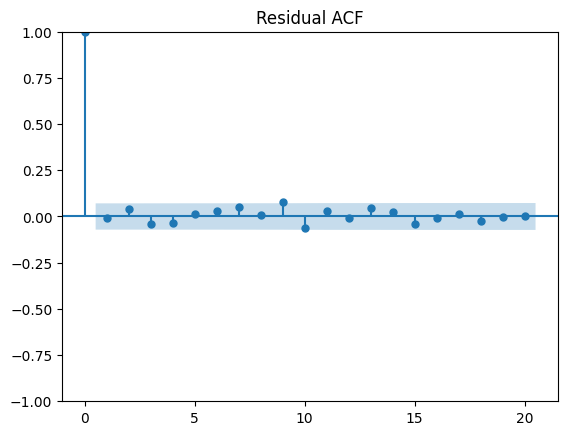

In [13]:
plt.subplot(1, 1, 1)
plot_acf(residuals.dropna(), ax=plt.gca(), lags=min(20, len(residuals)//4))
plt.title('Residual ACF')